1. Make a binary classification dataset with Scikit-Learn's make_moons() function.
 * For consistency, the dataset should have 1000 samples and a random_state=42.
 * Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.
 
2. Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
 * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

3. Setup a binary classification compatible loss function and optimizer to use when training the model.

4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
 * To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
 * Train the model for long enough for it to reach over 96% accuracy.
 * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

5. Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
 * Feel free to reference the ML cheatsheet website for the formula.

7. Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code).
 * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
 * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
 * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
* Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

In [17]:
import torch
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import torch.nn as nn

## 1. Make dataset

Make a binary classification dataset with Scikit-Learn's make_moons() function.
 * For consistency, the dataset should have 1000 samples and a random_state=42.
 * Turn the data into PyTorch tensors. Split the data into training and test sets using train_test_split with 80% training and 20% testing.

In [18]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [22]:
X, y = make_moons(n_samples=1000, noise=0.3, random_state=42)

In [23]:
# Turn the data into PyTorch Tensors

X = torch.from_numpy(X).type(torch.float32)
y = torch.from_numpy(y).type(torch.float32)
X[:10], y[:10]

(tensor([[-0.1719,  0.5962],
         [ 1.2533, -0.2654],
         [ 0.7232,  0.2319],
         [-0.0652, -0.6552],
         [-0.7995,  0.5529],
         [ 0.7113,  0.0737],
         [ 0.2625, -0.1785],
         [-0.1750,  0.5947],
         [ 1.5405, -0.3674],
         [ 0.8183,  1.0659]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

In [24]:
# Split data in Training and testing sets

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## 2. Build the model

Build a model by subclassing nn.Module that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
 * Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [25]:
class MoonModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=64)
        self.layer_3 = nn.Linear(in_features=64, out_features=128)
        self.layer_4 = nn.Linear(in_features=128, out_features=256)
        self.layer_5 = nn.Linear(in_features=256, out_features=256)
        self.layer_6 = nn.Linear(in_features=256, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_6(self.relu(self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(
               self.relu(self.layer_2(self.relu(self.layer_1(x)))))))))))

In [26]:
# device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"

device

'cuda'

In [27]:
moon_model = MoonModel().to(device)

moon_model.state_dict

<bound method Module.state_dict of MoonModel(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=256, bias=True)
  (layer_5): Linear(in_features=256, out_features=256, bias=True)
  (layer_6): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)>

## 3. Loss Function and Optimizer

Setup a binary classification compatible loss function and optimizer to use when training the model.

In [28]:
loss_fn = nn.BCEWithLogitsLoss() # Binary Cross Entropy

optimizer = torch.optim.SGD(params=moon_model.parameters(), lr=0.05) # w = w - lr * gradient(L, w)

## 4. Training and Testing loop

Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
 * To measure model accuray, you can create your own accuracy function or use the accuracy function in TorchMetrics.
 * Train the model for long enough for it to reach over 96% accuracy.
 * The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.


In [29]:
def accuracy_fn(y_preds, y_true):
    return ((y_preds == y_true).sum() / len(y_true)) * 100

In [30]:
# Put the data on GPU
X_train, y_train = X_train.to(device).type(torch.float), y_train.to(device).type(torch.float).unsqueeze(dim=1)
X_test, y_test = X_test.to(device).type(torch.float), y_test.to(device).type(torch.float).unsqueeze(dim=1)

In [31]:
torch.manual_seed(42)
epochs = 10000
epoch_values = []
loss_values = []
test_loss_values = []

# Loop
for epoch in range(epochs):
    ### Training
    moon_model.train()
    # Forward pass
    y_logits = moon_model(X_train)
    y_preds = torch.round(torch.sigmoid(y_logits))
    
    # Calculate the loss
    loss = loss_fn(y_logits, y_train)
    acc = accuracy_fn(y_preds, y_train)
    
    # Zero grads
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Gradient step (gradient descent)
    optimizer.step()
    
    ### Testing
    moon_model.eval()
    
    test_logits = moon_model(X_test)
    test_preds = torch.round(torch.sigmoid(test_logits))
    
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(test_preds, y_test)
    
    if epoch % 1000 == 0:
        epoch_values.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch : {epoch} | Loss : {loss: .4f}, acc : {acc: .2f}% | Test Loss : {test_loss: .4f}, Test acc: {test_acc: .2f}%")
moon_model.state_dict

Epoch : 0 | Loss :  0.6932, acc :  50.00% | Test Loss :  0.6929, Test acc:  50.00%
Epoch : 1000 | Loss :  0.2097, acc :  91.50% | Test Loss :  0.1792, Test acc:  93.50%
Epoch : 2000 | Loss :  0.1983, acc :  91.62% | Test Loss :  0.1685, Test acc:  94.00%
Epoch : 3000 | Loss :  0.1946, acc :  92.00% | Test Loss :  0.1677, Test acc:  94.00%
Epoch : 4000 | Loss :  0.1927, acc :  92.00% | Test Loss :  0.1669, Test acc:  94.00%
Epoch : 5000 | Loss :  0.1908, acc :  92.00% | Test Loss :  0.1673, Test acc:  94.00%
Epoch : 6000 | Loss :  0.1893, acc :  92.00% | Test Loss :  0.1673, Test acc:  94.00%
Epoch : 7000 | Loss :  0.1901, acc :  92.00% | Test Loss :  0.1687, Test acc:  93.50%
Epoch : 8000 | Loss :  0.1879, acc :  92.00% | Test Loss :  0.1685, Test acc:  94.00%
Epoch : 9000 | Loss :  0.1854, acc :  92.12% | Test Loss :  0.1687, Test acc:  93.50%


<bound method Module.state_dict of MoonModel(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=64, bias=True)
  (layer_3): Linear(in_features=64, out_features=128, bias=True)
  (layer_4): Linear(in_features=128, out_features=256, bias=True)
  (layer_5): Linear(in_features=256, out_features=256, bias=True)
  (layer_6): Linear(in_features=256, out_features=1, bias=True)
  (relu): ReLU()
)>

## 5. Predictions

Make predictions with your trained model and plot them using the plot_decision_boundary() function created in this notebook.

In [32]:
# Predictions
with torch.inference_mode():
    y_logits = moon_model(X_test)
    y_preds = torch.round(torch.sigmoid(y_logits))
y_preds[:10]

tensor([[1.],
        [0.],
        [1.],
        [0.],
        [1.],
        [1.],
        [0.],
        [0.],
        [1.],
        [0.]], device='cuda:0')

In [15]:
from helper_functions import plot_predictions, plot_decision_boundary

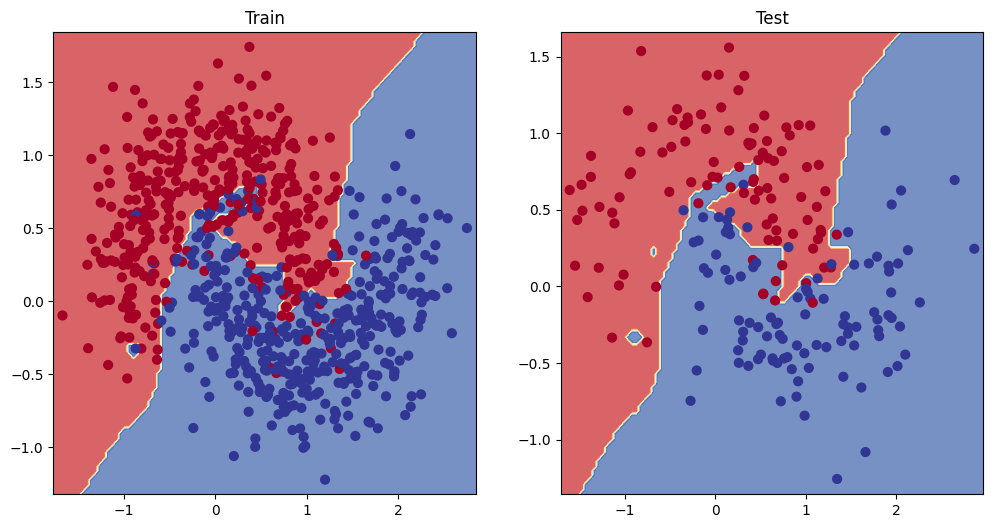

In [16]:
# Plot decision boundary of the model
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(moon_model, X_train, y_train)

plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(moon_model, X_test, y_test)

## 6. Replicate tanh activation function in PyTorch

Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.
 * Feel free to reference the ML cheatsheet website for the formula.

In [16]:
def tanh(z):
    return (torch.exp(z) - torch.exp(-z)) / (torch.exp(z) + torch.exp(-z))

## 7. Multiclass classification
 * Create a multi-class dataset using the spirals data creation function from CS231n (see below for the code). 
 * Construct a model capable of fitting the data (you may need a combination of linear and non-linear layers).
 * Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).
 * Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).
 * Plot the decision boundaries on the spirals dataset from your model predictions, the plot_decision_boundary() function should work for this dataset too.

###  7.1. Create a multi-class dataset

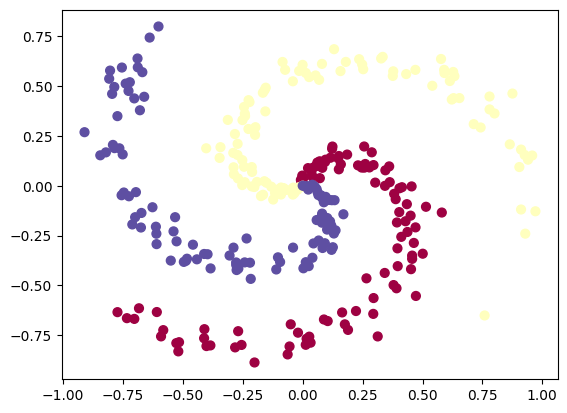

In [17]:
# Code for creating a spiral dataset from CS231n
import numpy as np
N = 100 # number of points per class
D = 2 # dimensionality
K = 3 # number of classes
X = np.zeros((N*K,D)) # data matrix (each row = single example)
y = np.zeros(N*K, dtype='uint8') # class labels
for j in range(K):
  ix = range(N*j,N*(j+1))
  r = np.linspace(0.0,1,N) # radius
  t = np.linspace(j*4,(j+1)*4,N) + np.random.randn(N)*0.2 # theta
  X[ix] = np.c_[r*np.sin(t), r*np.cos(t)]
  y[ix] = j
# lets visualize the data
plt.scatter(X[:, 0], X[:, 1], c=y, s=40, cmap=plt.cm.Spectral)
plt.show()

In [18]:
device = "cuda" if torch.cuda.is_available() else cpu

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [20]:
X_train, y_train = torch.from_numpy(X_train), torch.from_numpy(y_train)
X_test, y_test = torch.from_numpy(X_test), torch.from_numpy(y_test)

In [21]:
X_train, y_train = X_train.type(torch.float32).to(device), y_train.type(torch.float32).to(device)
X_test, y_test = X_test.type(torch.float32).to(device), y_test.type(torch.float32).to(device)

In [22]:
X_train[:5], y_train[:5]

(tensor([[ 0.0829, -0.3124],
         [ 0.5806, -0.1346],
         [ 0.0406,  0.0450],
         [ 0.5774,  0.6355],
         [ 0.5409,  0.5012]], device='cuda:0'),
 tensor([2., 0., 0., 1., 1.], device='cuda:0'))

### 7.2 Construct a model

In [23]:
class SpiralModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=32)
        self.layer_2 = nn.Linear(in_features=32, out_features=32)
        self.layer_3 = nn.Linear(in_features=32, out_features=64)
        self.layer_4 = nn.Linear(in_features=64, out_features=128)
        self.layer_5 = nn.Linear(in_features=128, out_features=1)
        self.relu = nn.ReLU()
    
    def forward(self, x:torch.Tensor) -> torch.Tensor:
        return self.layer_5(self.relu(self.layer_4(self.relu(self.layer_3(
            self.relu(self.layer_2(self.relu(self.layer_1(x)))))))))

spiral_model = SpiralModel().to(device)
spiral_model.state_dict

<bound method Module.state_dict of SpiralModel(
  (layer_1): Linear(in_features=2, out_features=32, bias=True)
  (layer_2): Linear(in_features=32, out_features=32, bias=True)
  (layer_3): Linear(in_features=32, out_features=64, bias=True)
  (layer_4): Linear(in_features=64, out_features=128, bias=True)
  (layer_5): Linear(in_features=128, out_features=1, bias=True)
  (relu): ReLU()
)>

### 7.3 Loss function and Optimizer

Build a loss function and optimizer capable of handling multi-class data (optional extension: use the Adam optimizer instead of SGD, you may have to experiment with different values of the learning rate to get it working).

In [24]:
loss_fn = nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(params=spiral_model.parameters(), lr=0.01)

### 7.4. Training and testing loop

Make a training and testing loop for the multi-class data and train a model on it to reach over 95% testing accuracy (you can use any accuracy measuring function here that you like).

In [25]:
from torchmetrics import Accuracy

torchmetrics_accuracy = Accuracy(task="multiclass", num_classes=3)

In [28]:
device

'cuda'

In [29]:
torch.cuda.is_available()

True

In [ ]:
torch.manual_seed(42)
epochs = 10
epoch_values = []
loss_values = []
test_loss_values = []

# Loop
for epoch in range(epochs):
    ### Training
    spiral_model.train()
    
    # Forward pass
    y_logits = spiral_model(X_train)
    y_probs = torch.softmax(y_logits, dim=1)
    y_preds = torch.argmax(y_probs, dim=1)
    
    # Calculate the loss
    loss = loss_fn(y_logits, y_train.type(torch.LongTensor).to(device))
    acc = accuracy_fn(y_preds, y_train)
    
    # Zero grads
    optimizer.zero_grad()
    
    # Backpropagation
    loss.backward()
    
    # Optimization step (gradient descent)
    optimizer.step()
    
    ### Testing
    spiral_model.eval()
    
    test_logits = spiral_model(X_test)
    test_probs = torch.softmax(test_logits, dim=1)
    test_preds = torch.argmax(test_probs, dim=1)
    
    test_loss = loss_fn(test_logits, y_test.type(torch.LongTensor).to(device))
    test_acc = accuracy_fn(test_preds, y_test)
    
    if epoch % 10 == 0:
        epoch_values.append(epoch)
        loss_values.append(loss)
        test_loss_values.append(test_loss)
        print(f"Epoch: {epoch} | Loss: {loss :.4f}, Acc: {acc: .2f}% | Test loss: {test_loss:.2f}, Test Acc: {test_acc: .2f}%")
spiral_model.state_dict